# Homework 4 
## Part 1: The $L^2$ Projection in 2D

### This is the solution of:
* Tor Djupman
* Isac Östman
* Felix Svedberg


The same general rules as for Homework 1 applies.

$\newcommand{\dx}{\,\mathrm{d}x}$ 
$\newcommand{\dy}{\,\mathrm{d}y}$
$\newcommand{\dS}{\,\mathrm{d}S}$

In [12]:
# Make plotted figures interactive
%matplotlib inline

Import relevant python modules and our own tiny helper modules.

In [13]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

## Problem 1 (Exploring the meshtools module)

Download $\texttt{meshtools}$ module from Canvas. 
Import it as usual via

and play around with the implemented functions. In particular, generate and plot 

**a**) a unitsquare mesh with meshsize $h = 1/N$ for $N=1,2,5$.

**b**) 3 rectangle meshes for $[a,b]\times[c,d] = [0,1]\times[2,4]$ for 
3 meshsizes of your choice.

Hint: read the code meshtools.py 

In [14]:
import meshtools as mt
import plottools as pt

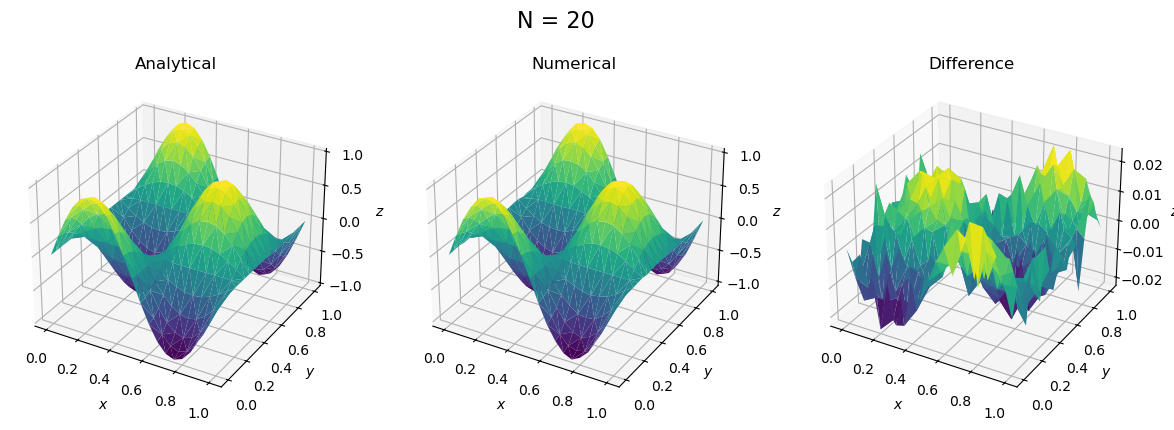

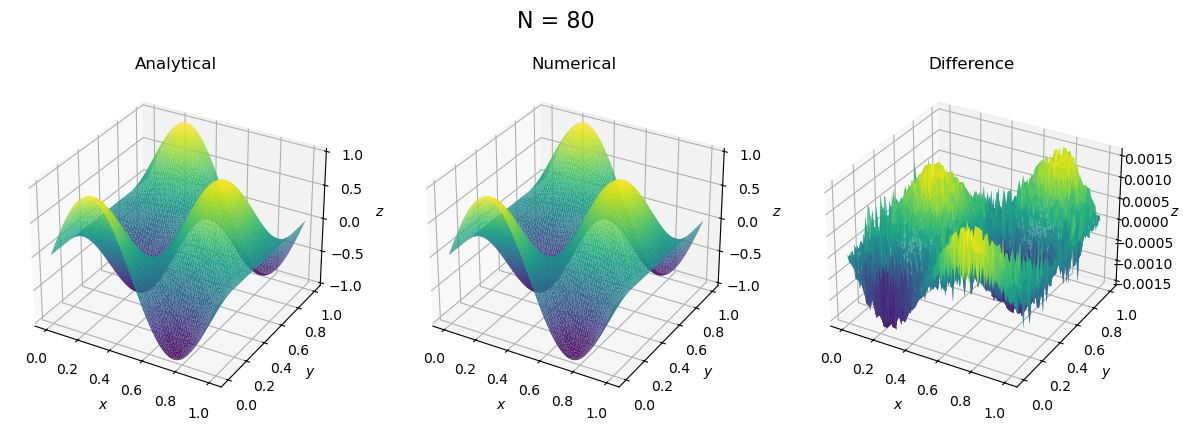

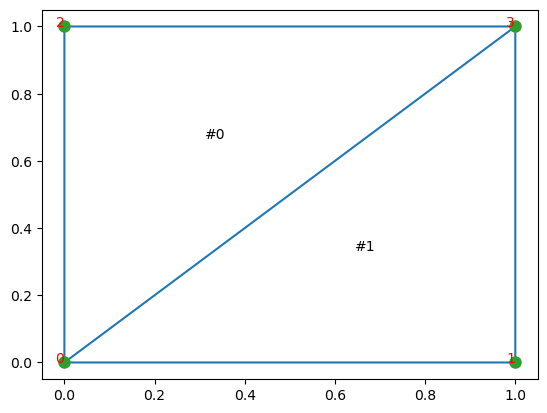

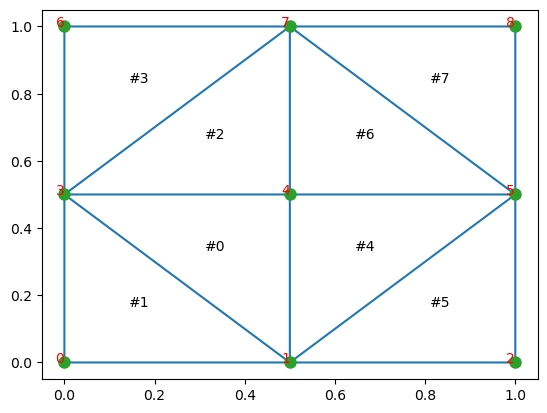

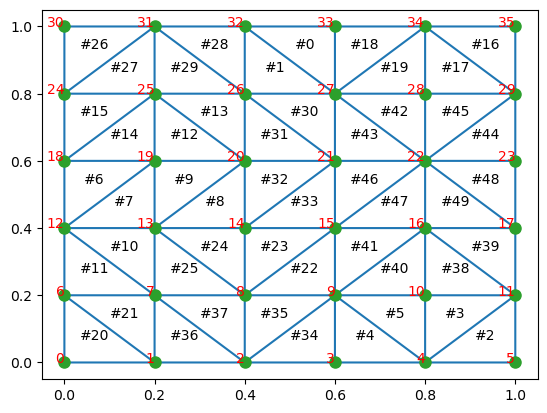

In [15]:
for i,N in enumerate([1, 2, 5]):
    P, T = mt.unitsquare_mesh(N)
    pt.plot_mesh_2d(P,T)

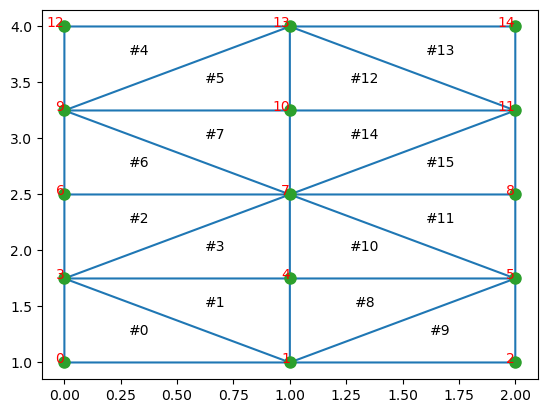

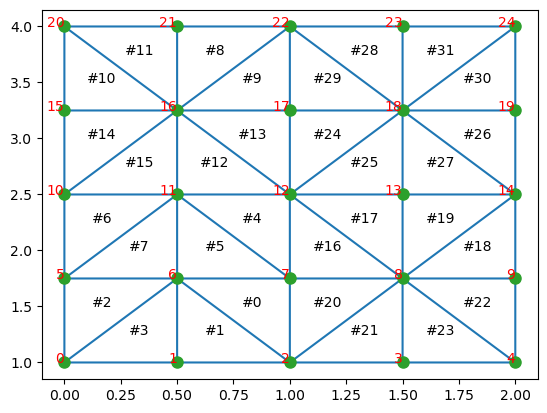

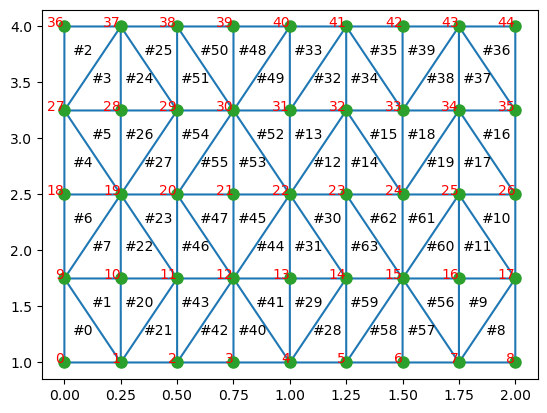

In [16]:
for N in [2, 4, 8]:
    p = (0,1)
    q = (2,4)
    M = i*2
    P, T = mt.rectangle_mesh(p, q, N, M)

    # Plot mesh
    pt.plot_mesh_2d(P, T)

## Problem 2 ($L^2$ projection)

**a**) For a given domain, let $\mathcal{K}_h = \{K_i\}_{i=0}^{n_t-1}$ be a triangulation represent through its point matrix $P$ and its connectivity matrix $T$. As usual, let $V_h$
be the space of continuous, piecewise linear functions defined on $\mathcal{K}_h$

Write a Python function ```assemble_mass_matrix(P, T)``` which assembles the mass
matrix associated with the $L^2$ projection onto $V_h$. Start from the following code outline.

**b**) Next, write a Python function ```assemble_load_vector(P, T, f)``` 
which assembles the corresponding load vector for a given triangulation $\mathcal{K}_h$ and a right-hand side function f. You shall implement two quadratures (2D Trapezoid and midpoint)to approximate the local element vector

$$
b^K = \int_K f \lambda_i \approx Q_K^{cp}(f\lambda_i) \quad i = 0,1,2
$$

**c)** Finally, we have all the bits and pieces together to compute for a given triangulation $\mathcal{K}_h$ the $L^2$ projection of the analytical function  $f:\Omega \to \mathbb{R}$ defined by

$$
f(x,y) = \sin(2\pi x)\cos(2\pi y),
\quad \Omega = [0,1]^2 \subset \mathbb{R}^2.$$

More specifically, compute $P_h f$ on a series of meshes $\{\mathcal{K}_h\}$
with $h = 1/N$ and $N = 5, 10, 20, 40, 80$.
Plot both $f$, $P_h f$ and the error function $f - P_h f$ for $N = 5, 20, 80$.  Use the 2d Trapezoid rule in the assemble_load_vector.

You can use the following convenient function to plot $f$, $P_h f$ and $f - P_h f$.

**d)** Repeat the numerical experiement c) using 
2D midpoint rule in the load vector assembly. 
Describe qualitively the difference and explain why.

### Answer 
__d)__ For midpoint we can see that the error for $N = 80$ looks similar to an inverse of the exact solution. This is because midpoint will overshoot at local maxima and minima, when evaluating between nodes. Thus, curved regions cause systematic over/under-estimation. In contrast, trepezoidal is exact at the nodes and gives a better accuracy at those specific points. But it will give a less accurate description of the behavior between the points, which is specifically noticable at the boundaries.

### Functions [ a) & b) ] 

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm
import meshtools as mt
import plottools as pt

In [18]:
def assemble_mass_matrix(P, T):
    # Define constant part M_K here
    M_ref = 1/12*np.array([[2, 1, 1], 
                           [1, 2, 1], 
                           [1, 1, 2]])
    
    # Deduce number of unkowns from dimensions/shape of P
    n_p = P.shape[0]
    # Deduce number of elements from dimensions of T
    n_t = T.shape[0]
    
    # Create sparse matrix M
    M = sp.dok_matrix((n_p, n_p))
    
    for  K in range(n_t):
        # Get local to global map from T
        l2g = T[K]
        # Get triangle nodes from P
        tri = P[T[K]]
        # Unpack nodes into N1,N2,N3
        N0,N1,N2 = tri 
        # Compute area of K. 
        # Convince yourself that the following line computes the area |K|
        # area = 0.5 * abs((N1[0] - N0[0])*(N2[1] - N0[1]) -
        #                (N1[1] - N0[1])*(N2[0] - N0[0]))
        area = abs(0.5*np.cross(N1-N0, N2-N0))
        # Use area and M_ref to compute M_K
        M_K = area*M_ref
        # Instead of 2 loops we can slice out the blocks which
        # corresponds to the entries in l2g by using the funny
        # function ix_ in numpy
        M[np.ix_(l2g, l2g)] += M_K
    
    return M

In [19]:
def assemble_load_vector(P, T, f, qr = "midpoint_2d"):
    """ Assembles the load vector """
    
    # Deduce number of unkowns from dimensions/shape of P
    n_p = P.shape[0]
    # Deduce number of elements from dimensions of T
    n_t = T.shape[0]
    
    
    # Create and intialize vector
    b = np.zeros(n_p)
    
    # Iterate over all triangles
    for  K in range(n_t):
        l2g = T[K]   # Get local to global map
        tri = P[T[K]]  # Get triangle coordinates and compute area
        N0,N1,N2 = tri 
        #area = 0.5 * abs((N1[0] - N0[0])*(N2[1] - N0[1]) -
        #                (N1[1] - N0[1])*(N2[0] - N0[0]))
        area = abs(0.5*np.cross(N1-N0, N2-N0))
        if qr == "midpoint_2d":   
            # 2d midpoint
            # three midpoint coordinates
            N01 = (N0 + N1)/2
            N12 = (N1 + N2)/2
            N20 = (N0 + N2)/2
            
            b_K = area/6*np.array([f(N01)+f(N20), f(N01)+f(N12), f(N12)+f(N20)])
            # b_K = area/3*np.array([f(N01), f(N12), f(N20)])            
        else:
            # 2d Trapezoid
            b_K = area/3*np.array([f(N0), f(N1), f(N2)])
        # Add local contributions to the global load vector
        b[l2g] += b_K
        
    return b

In [20]:
def plot_comparison_2D(X, Y, f1, f2, triangles, N, title_f1='', title_f2=''):
    fig = plt.figure(figsize=plt.figaspect(0.33))
    fig.suptitle(f"N = {N}", fontsize=16)
    
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.plot_trisurf(X, Y, f1, triangles=triangles.copy(), cmap=cm.viridis, linewidth=0.0)
    ax.set_title(title_f1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

    # Plot projected function
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.plot_trisurf(X, Y, f2, triangles=triangles.copy(), cmap=cm.viridis, linewidth=0.0)
    ax.set_title(title_f2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.plot_trisurf(X, Y, f1-f2, triangles=triangles.copy(), cmap=cm.viridis, linewidth=0.0)
    ax.set_title('Difference')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    plt.show()

### __c)__

/var/folders/y0/3xglwysx2hnc0mrw17d9bzb40000gp/T/ipykernel_89177/543912631.py:26: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = abs(0.5*np.cross(N1-N0, N2-N0))
/var/folders/y0/3xglwysx2hnc0mrw17d9bzb40000gp/T/ipykernel_89177/3564858816.py:20: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = abs(0.5*np.cross(N1-N0, N2-N0))


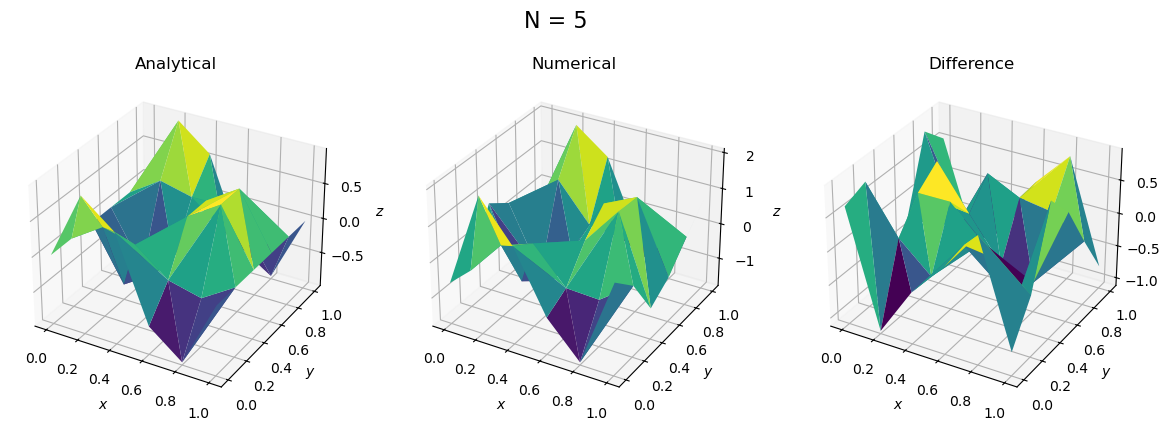

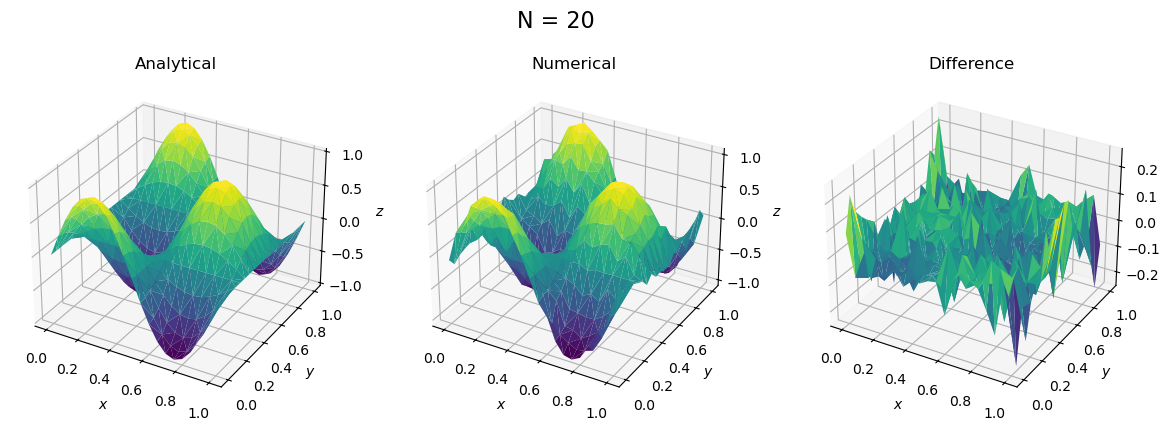

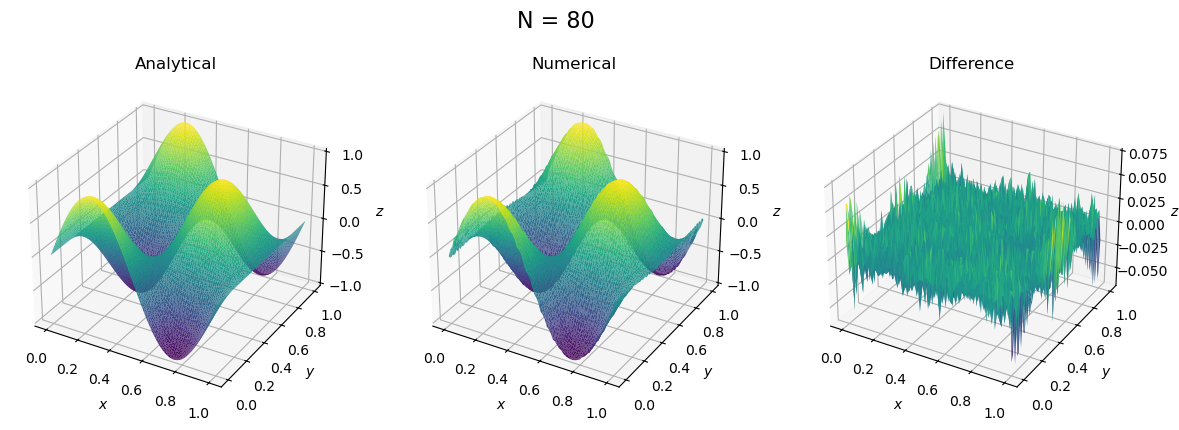

In [21]:
for i in range(5):
    # Declarations 
    N = 5 * 2**i
    h = 1/N
    f = lambda x: np.sin(2*np.pi*x[0])*np.cos(2*np.pi*x[1])
    
    # Build M and b:
    P, T = mt.unitsquare_mesh(N)
    M = assemble_mass_matrix(P, T)
    b = assemble_load_vector(P, T, f, qr = "trapezoid")
    
    # Solve linear algebra system 
    M_csr = M.tocsr() 
    Ph_f = spsolve(M_csr, b)
    
    if np.mod(i,2) == 0:
        X = P[:,0]
        Y = P[:,1]
        plot_comparison_2D(X, Y, f([X,Y]), Ph_f, T, N, title_f1='Analytical', title_f2='Numerical')
    
    

### __d)__

/var/folders/y0/3xglwysx2hnc0mrw17d9bzb40000gp/T/ipykernel_89177/543912631.py:26: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = abs(0.5*np.cross(N1-N0, N2-N0))
/var/folders/y0/3xglwysx2hnc0mrw17d9bzb40000gp/T/ipykernel_89177/3564858816.py:20: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = abs(0.5*np.cross(N1-N0, N2-N0))


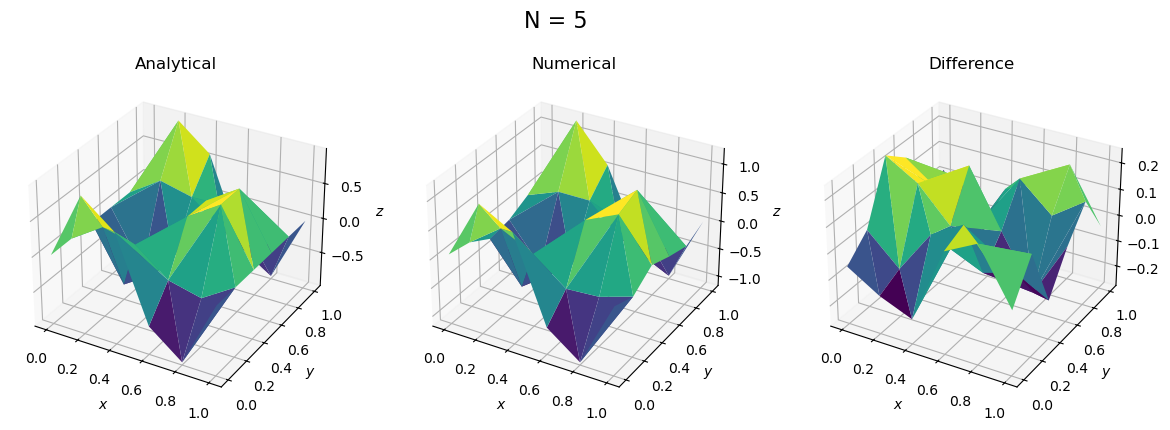

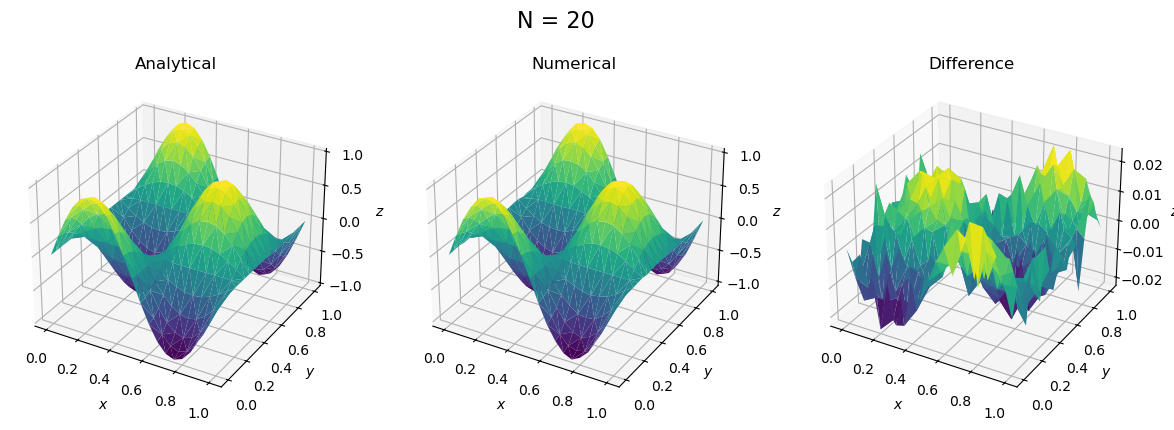

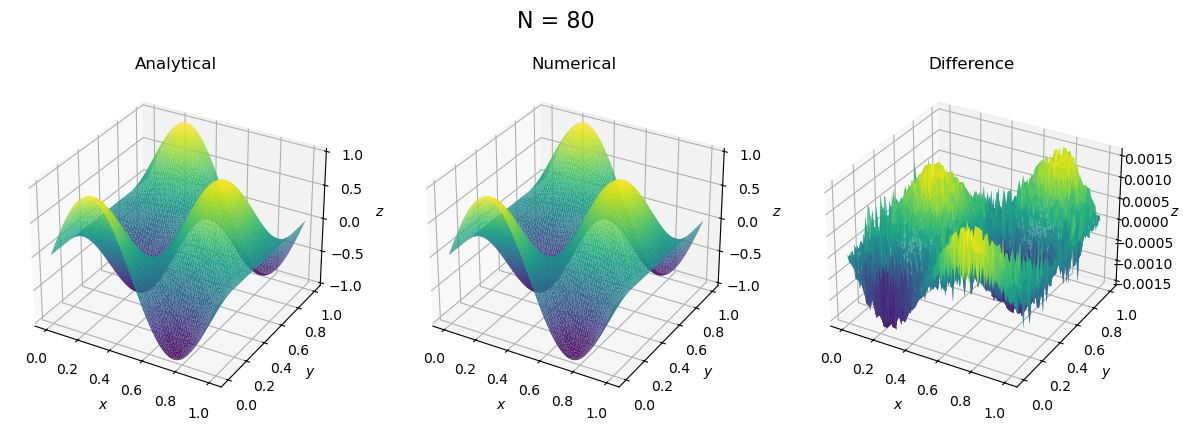

In [22]:
for i in range(5):
    # Declarations 
    N = 5 * 2**i
    h = 1/N
    f = lambda x: np.sin(2*np.pi*x[0])*np.cos(2*np.pi*x[1])
    
    # Build M and b:
    P, T = mt.unitsquare_mesh(N)
    M = assemble_mass_matrix(P, T)
    b = assemble_load_vector(P, T, f, qr = "midpoint_2d")
    
    # Solve linear algebra system 
    M_csr = M.tocsr() 
    Ph_f = spsolve(M_csr, b)
    
    if np.mod(i,2) == 0:
        X = P[:,0]
        Y = P[:,1]
        plot_comparison_2D(X, Y, f([X,Y]), Ph_f, T, N, title_f1='Analytical', title_f2='Numerical')